In [1]:
import numpy as np
from scipy.optimize import curve_fit
from src import *
import matplotlib.pyplot as plt


# OCC

In [2]:
 # from the meta analysis: https://inldigitallibrary.inl.gov/sites/sti/sti/Sort_107010.pdf\n# Table 29
 # # Large reactors
 
 OCC_large_conservative = 7750 # USD/kW
 OCC_large_moderate = 5750
 cons_duration_large_conservative = 125 #(months)
 
 cons_duration_large_moderate = 82 #(months)
 power_large_ref = 1000 # MWe
 
 # SMR
 OCC_SMR_conservative = 10000 # USD/kW
 OCC_SMR_moderate = 7750 
 cons_duration_SMR_conservative = 71 #(months)
 cons_duration_SMR_moderate = 55 #(months)
 power_SMR_ref = 200 # MWe # the average power of the SMR in the sheet is 200 
 
 
 #Microreactors\n# from the lit review : https://www.osti.gov/biblio/1986466: Table 17 (scaled data) only OCC. The data that had the financing cost were excluded
 # # all of them are multuplied by 1.175625 (inflation multuplier from 2019 to 2023) using :https://fred.stlouisfed.org/series/GDPDEF#0\n
 MR_cost_1  = 10000 * 1.175625 
 MR_cost_2 = + 15000 *1.175625
 MR_cost_3 =  20000 * 1.175625
 MR_cost_4 = 3996 * 1.175625  
 MR_cost_5 = 8276  * 1.175625 
 MR_cost_6 = 14973 * 1.175625
 MR_cost_average =np.mean ([MR_cost_1,MR_cost_2, MR_cost_3, MR_cost_4,MR_cost_5, MR_cost_6 ])
 MR_cost_std = np.std ([MR_cost_1,MR_cost_2, MR_cost_3, MR_cost_4,MR_cost_5, MR_cost_6 ])
 
power_micro_ref = 5 # MW
cons_duration_micro_conservative = 36 #(months) # I assumed this!
 
OCC_micro_conservative = MR_cost_average + MR_cost_std # USD/kW
OCC_micro_moderate = MR_cost_average
 
 # now lets do curve fitting\n
def large_reactor_func(x, a, b):  
    return a*(x**b)

xdata1 = [ power_large_ref,  power_SMR_ref,power_micro_ref ]
ydata1 = [ OCC_large_conservative,  OCC_SMR_conservative, OCC_micro_conservative  ]
popt1, p_cov1 = curve_fit(large_reactor_func, xdata1 , ydata1)

def occ_for_power(P):
    return popt1[0] *(P**popt1[1]) # $/kw

def construction_duration_power(P):
    if P > 500:
        duration =  cons_duration_large_conservative
    if P <= 500 and P > 50:
         duration =  cons_duration_SMR_conservative
    elif P<= 50:     
        duration =  cons_duration_micro_conservative
    return duration



print("OCCs for large, small, microreactors are : " , OCC_large_conservative,  OCC_SMR_conservative, OCC_micro_conservative , "$/kw" )

OCCs for large, small, microreactors are :  7750 10000 20297.3421381159 $/kw


# TCI

In [3]:
def capital_investment(P, interest_rate):
    construction_duration = construction_duration_power(P)
    tot_overnight_cost = occ_for_power(P)
    
    # Interest rate from this equation (from Levi)
    B =(1+ np.exp((np.log(1+ interest_rate)) * construction_duration/12))
    C  =((np.log(1+ interest_rate)*(construction_duration/12)/3.14)**2+1)
    Interest_expenses = tot_overnight_cost*((0.5*B/C)-1)
    return (Interest_expenses + tot_overnight_cost) # this is TCI in $/kw

def tot_TCI_multiple_reactors (P, interest_rate, num_reactors): # multiple reactors of the same power

    # the capital investment of one reactor ($/kw)
    levlized_TCI = capital_investment(P, interest_rate)
    
    if P >500:
        learning_rate = 0.08
    elif P<=500 :
        learning_rate = 0.095 
    
    # the capital investment of one reactor ($/kw) after the learning rate effect
    final_TCI = calculate_final_cost_due_to_learning_rate(levlized_TCI, learning_rate, num_reactors ) # This is still cost per kw
    final_TCI_one_reactor = final_TCI *P*1000 #(Dollar)
    final_TCI_all_reactors = final_TCI_one_reactor *num_reactors 
    return final_TCI_all_reactors # (dollars)

interest_rate = 0.06
print("TCIs for large, small, microreactors are : " ,\
    np.round(capital_investment( power_large_ref, interest_rate), 0),  np.round(capital_investment( power_SMR_ref, interest_rate), 0),\
        np.round(capital_investment(power_micro_ref , interest_rate), 0), "$/kw" )

print("Total TCIs for large, small, microreactors are : " , np.round(tot_TCI_multiple_reactors( power_large_ref, interest_rate, 1)/1000000000, 2),\
    np.round(tot_TCI_multiple_reactors( power_SMR_ref, interest_rate, 1)/1000000000, 2), np.round(tot_TCI_multiple_reactors(power_micro_ref , interest_rate, 1)/1000000000, 2), "USD (billions)" )

TCIs for large, small, microreactors are :  10331.0 12154.0 22134.0 $/kw
Total TCIs for large, small, microreactors are :  10.33 2.43 0.11 USD (billions)


In [4]:
# interest_rate = 0.06
# demand =  1000
# print("The total cost of 1000 MW (in billions of dollars)")
# print(f"{power_large_ref} MW : ",tot_TCI_multiple_reactors (power_large_ref,interest_rate , int(demand/power_large_ref))/1000000000)
# print( f"{power_SMR_ref} MW : " ,tot_TCI_multiple_reactors (power_SMR_ref, interest_rate, int(demand/power_SMR_ref))/1000000000)
# print( f"{power_micro_ref} MW : "  , tot_TCI_multiple_reactors (power_micro_ref, interest_rate, int(demand/power_micro_ref))/1000000000)
# print( f"{1} MW : "  , tot_TCI_multiple_reactors (1, interest_rate, int(demand/1))/1000000000)

In [5]:
# # number of reactors to achieve the target demand 
# refueling_period = 30 /7) # days
# levelization_period = 30*365

# fuel_lifetime = 2*12*30


# demand_0 = 1000 # MWe
# power_list = [1000, 500, 300] #, 100, 50, 10, 5, 1]
# capacity_factor_criteria_list = [0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.999, 0.9999, 0.99999, 1]
# num_reactors_save_tot = []
# TCI_all_reactors_save_tot = []

# for power in power_list :
#     num_reactors_save = []
#     TCI_all_reactors_save = []
#     num_reactors_current = 0 # initialization
#     for capacity_factor_criteria in capacity_factor_criteria_list :
    
#         num_reactors_0 =  max( int( np.ceil( demand_0 /power)), num_reactors_current)
#         for  num_reactors in np.linspace( num_reactors_0 , 2*num_reactors_0, 1+num_reactors_0):
            
                
#             times_array_excludingRampUp = (capacity_factor_weeks_approach(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[0]
#             # capacity_factor_min =        min ((capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[1])
#             overall_capacity_factor   =   (capacity_factor(fuel_lifetime, refueling_period, int(num_reactors), power, levelization_period, demand_0 ))[2]
#             # print( power, num_reactors, capacity_factor_criteria, overall_capacity_factor  )
            
#             if  overall_capacity_factor>=  capacity_factor_criteria:
#                 num_reactors_save.append(num_reactors)
#                 TCI_all_reactors = tot_TCI_multiple_reactors (power, 0.075, int(num_reactors)) # assume 7.5 % interest rate # $ /kw
#                 TCI_all_reactors_save.append(TCI_all_reactors)
#                 print(power, num_reactors, TCI_all_reactors )
#                 num_reactors_current = int(num_reactors)
                
#                 break
    
            
#     num_reactors_save_tot.append(num_reactors_save)    
#     TCI_all_reactors_save_tot.append( TCI_all_reactors_save)  

# Annualized Cost

In [6]:
# One of the shortcomings here is that the O&M cost is independent of the fuel lifetime
#Large reactor O&M Costs 
OM_large_hi = 39.8 # Total O&M ($/MWh)
OM_large_medium = 34.6 # Total O&M ($/MWh)

# SMR
OM_SMR_hi = 41.4  # Total O&M ($/MWh)     
OM_SMR_medium = 30.2 # Total O&M ($/MWh)

#Microreactors
# https://inldigitallibrary.inl.gov/sites/sti/sti/Sort_66425.pdf: TABLE 18
 # # multuplied by 1.175625 (inflation multuplier from 2019 to 2023) using :https://fred.stlouisfed.org/series/GDPDEF#0\n

OM_Micro_Avg = 1.175625*np.mean([69, 103, 137, 125, 136, 59]) # 2019$/MWh
OM_Micro_std = 1.175625*np.std([69, 103, 137, 125, 136, 59]) # 2019$/MWh
OM_Mirco_medium = OM_Micro_Avg # $/MWh
OM_Mirco_hi = OM_Micro_Avg+OM_Micro_std # $/MWh

print("O&M cost for large, SMR, microreactors ($/MWh) are ", OM_large_hi , OM_SMR_hi, OM_Mirco_hi )

# def OM_cost_per_MWh(P):
#     if P>500:
#         OM_cost = OM_large_hi
#     elif P<= 500 and P >50:
#         OM_cost = M_SMR_hi
#     elif  P <=50:  
#         OM_cost = OM_Mirco_hi 
    
#     return OM_cost   # $ /MWh   
      
      
def func_OM(x, a, b):  
    return a*(x**b)

xdata = [ power_large_ref,  power_SMR_ref, power_micro_ref ]
ydata = [ OM_large_hi,  OM_SMR_hi, OM_Mirco_hi  ]
popt_, p_cov_ = curve_fit(func_OM, xdata , ydata)

def OM_cost_per_MWh(power):
    return popt_[0] *(power**popt_[1]) # $/Mwh        

O&M cost for large, SMR, microreactors ($/MWh) are  39.8 41.4 159.79897990810207


In [7]:
# Electricity Prices
# According to: https://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=epmt_5_6_a
# The US total cost of electircy in Apri 2023 is 12.18 cents / kwh and the minimum was 7.59 (dakota)
elec_price_tot = 121.8   # dollar /MWh
elec_price_min = 75.8   # dollar /MWh

# LCOE

In [8]:
def level_cost_of_energy(levelization_period_years, interest_rate, P, num_reactors, list_of_generated_MWh_per_year_from_all_reactors, list_of_sold_electricity_MWh_per_year_from_all_reactors):
    sum_cost = 0 # initialization 
    sum_elec = 0 # initialization 
          
           
    for year in range(0, levelization_period_years+1):
        if year == 0:
            cap_cost =  tot_TCI_multiple_reactors (P, interest_rate, num_reactors) 
            OM_cost_per_year = 0
            elec_gen = 0
        elif year > 0:
            cap_cost = 0 
            OM_cost_per_year = OM_cost_per_MWh(P) * list_of_generated_MWh_per_year_from_all_reactors[year-1]
            revenue = list_of_sold_electricity_MWh_per_year_from_all_reactors[year-1]
            elec_gen = elec_price_min * list_of_generated_MWh_per_year_from_all_reactors[year-1]
        
        sum_cost += (cap_cost + OM_cost_per_year - elec_gen) / ((1 +interest_rate)**(year) ) 
        sum_elec += elec_gen/ ((1 + interest_rate)**year) 
    
    LCOE =  sum_cost/ sum_elec
    return LCOE    

# levelization_period_years = int(30)
# interest_rate = 0.06
# P = 500
# num_reactors = int(6000/P)
# list_of_generated_MWh_per_year_from_all_reactors = [num_reactors *P * 8760*0.95]*30
# level_cost_of_energy(levelization_period_years, interest_rate, P, num_reactors, list_of_generated_MWh_per_year_from_all_reactors)

# TCI for target demand and reliability

500 0.9 1000 2 19.835820151856428
500 0.9 900 2 18.205714688133277
500 0.9 800 2 16.541475203500788
500 0.9 700 2 14.837955883208663
500 0.9 600 2 13.088367670878716
500 0.9 500 2 9.762094609186546
500 0.9 400 3 11.788858042596704
500 0.9 300 3 9.327880771398567
500 0.9 200 4 8.696897075911144
500 0.9 100 6 7.112126583533137
500 0.9 50 10 5.830485175237038
500 0.9 20 25 6.166334782158113
500 0.9 5 100 6.616733600808382
500 0.9 1 500 7.114138617280409
500 0.94 1000 2 19.835820151856428
500 0.94 900 2 18.205714688133277
500 0.94 800 2 16.541475203500788
500 0.94 700 2 14.837955883208663
500 0.94 600 2 13.088367670878716
500 0.94 500 2 9.762094609186546
500 0.94 400 3 11.788858042596704
500 0.94 300 3 9.327880771398567
500 0.94 200 4 8.696897075911144
500 0.94 100 6 7.112126583533137
500 0.94 50 11 6.340942832146583
500 0.94 20 25 6.166334782158113
500 0.94 5 100 6.616733600808382
500 0.94 1 500 7.114138617280409
500 0.98 1000 2 19.835820151856428
500 0.98 900 2 18.205714688133277
500 0.9

/var/folders/fn/9991pz_174vgdscjw2zf2tbxtn5546/T/ipykernel_66848/2509332856.py:62: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,  10*np.ceil(max(tot_TCI_list)/10)          )


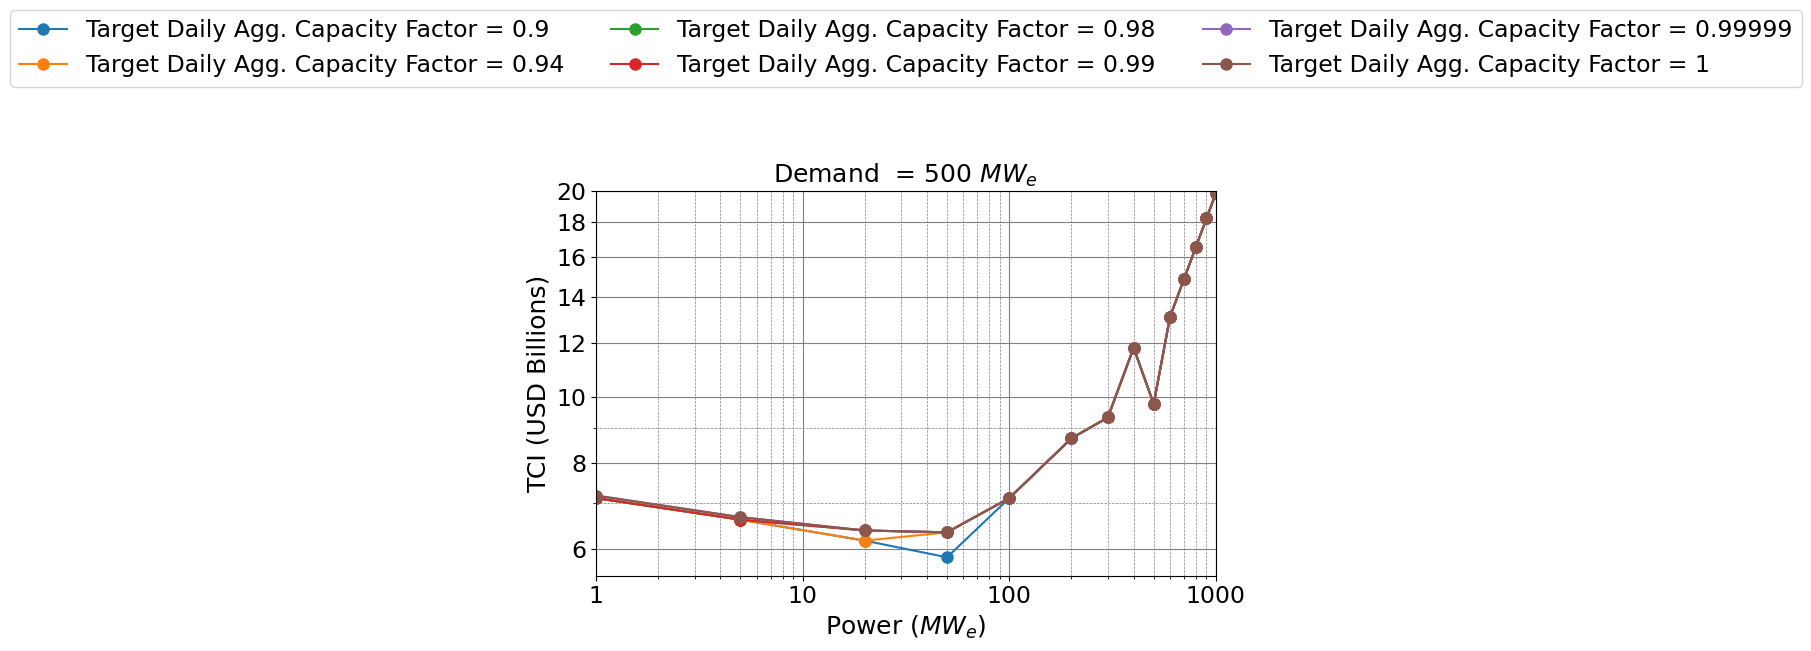

1000 0.9 1000 2 19.835820151856428
1000 0.9 900 2 18.205714688133277
1000 0.9 800 3 24.09027789075109
1000 0.9 700 3 21.60934718093051
1000 0.9 600 3 19.061323760353684
1000 0.9 500 3 14.136687632262982
1000 0.9 400 4 15.288867895808286
1000 0.9 300 4 12.097247786550668
1000 0.9 200 6 12.502891875665036
1000 0.9 100 10 11.182111285861039
1000 0.9 50 20 10.70332290056413
1000 0.9 20 50 11.245762104509716
1000 0.9 5 200 12.009358368323046
1000 0.9 1 1000 12.886952689599129
1000 0.94 1000 2 19.835820151856428
1000 0.94 900 3 26.514003173310655
1000 0.94 800 3 24.09027789075109
1000 0.94 700 3 21.60934718093051
1000 0.94 600 3 19.061323760353684
1000 0.94 500 3 14.136687632262982
1000 0.94 400 4 15.288867895808286
1000 0.94 300 5 14.779035982549491
1000 0.94 200 6 12.502891875665036
1000 0.94 100 11 12.161102597000136
1000 0.94 50 20 10.70332290056413
1000 0.94 20 50 11.245762104509716
1000 0.94 5 200 12.009358368323046
1000 0.94 1 1000 12.886952689599129
1000 0.98 1000 2 19.83582015185642

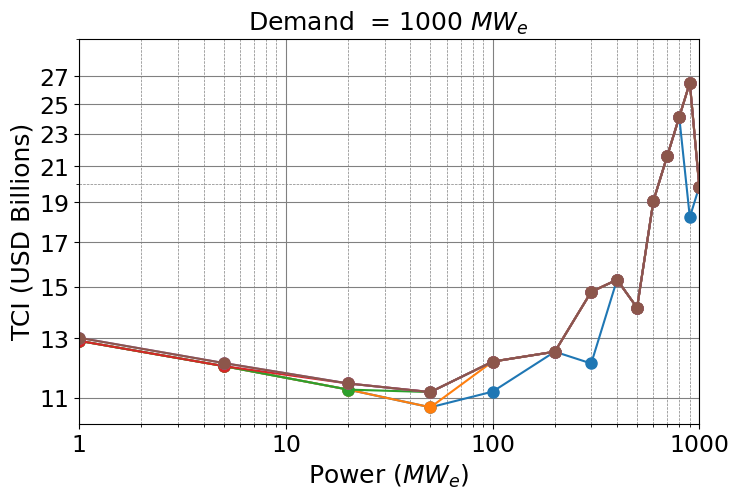

3000 0.9 1000 4 37.63230788412148
3000 0.9 900 4 34.539689064996075
3000 0.9 800 5 38.481209745332706
3000 0.9 700 5 34.51823283650691
3000 0.9 600 6 35.94320330530637
3000 0.9 500 7 30.229174098276072
3000 0.9 400 8 28.376203588757644
3000 0.9 300 10 27.343685719506645
3000 0.9 200 15 28.066707491753554
3000 0.9 100 30 29.210250337234786
3000 0.9 50 60 27.751141043141505
3000 0.9 20 150 28.984944088301383
3000 0.9 5 600 30.82545221816899
3000 0.9 1 3000 33.02476691220734
3000 0.94 1000 4 37.63230788412148
3000 0.94 900 5 42.352808129801666
3000 0.94 800 5 38.481209745332706
3000 0.94 700 6 40.74791283041102
3000 0.94 600 6 35.94320330530637
3000 0.94 500 7 30.229174098276072
3000 0.94 400 9 31.49043840686214
3000 0.94 300 11 29.737619212885754
3000 0.94 200 16 29.697337490042663
3000 0.94 100 30 29.210250337234786
3000 0.94 50 60 27.751141043141505
3000 0.94 20 150 28.984944088301383
3000 0.94 5 600 30.82545221816899
3000 0.94 1 3000 33.02476691220734
3000 0.98 1000 4 37.6323078841214

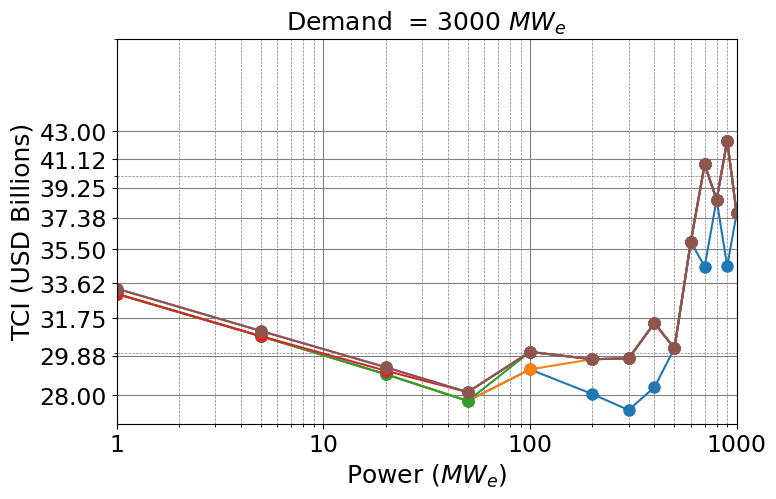

6000 0.9 1000 7 62.64803432675452
6000 0.9 900 7 57.49962592892983
6000 0.9 800 8 58.95208204314332
6000 0.9 700 9 58.8140357806129
6000 0.9 600 10 57.046708608967656
6000 0.9 500 12 48.65116940046276
6000 0.9 400 15 49.34037730540311
6000 0.9 300 20 50.19621673860535
6000 0.9 200 30 51.35068918389886
6000 0.9 100 60 53.223074603121376
6000 0.9 50 120 50.432234034733895
6000 0.9 20 300 52.56946351857414
6000 0.9 5 1200 55.83299865526496
6000 0.9 1 6000 59.786445326083246
6000 0.94 1000 7 62.64803432675452
6000 0.94 900 8 64.88325694928041
6000 0.94 800 9 65.56637060659843
6000 0.94 700 10 64.6724302760432
6000 0.94 600 11 62.155412402401566
6000 0.94 500 13 52.19300756203517
6000 0.94 400 16 52.20697287542971
6000 0.94 300 20 50.19621673860535
6000 0.94 200 30 51.35068918389886
6000 0.94 100 60 53.223074603121376
6000 0.94 50 120 50.432234034733895
6000 0.94 20 300 52.56946351857414
6000 0.94 5 1200 55.83299865526496
6000 0.94 1 6000 59.786445326083246
6000 0.98 1000 7 62.6480343267545

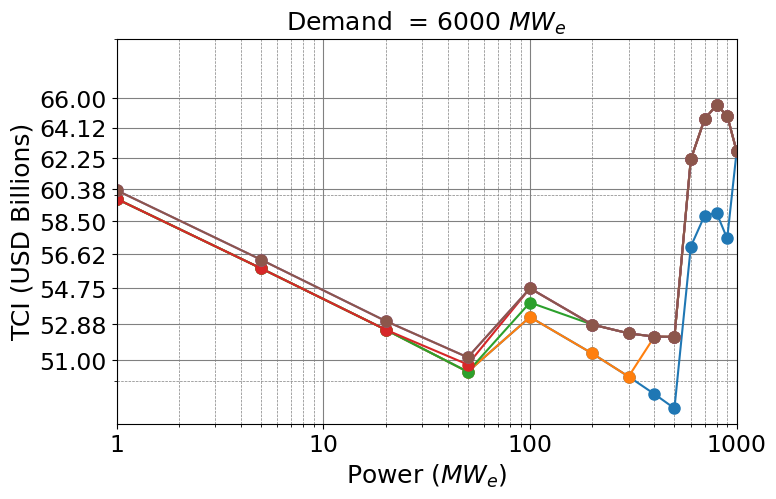

In [50]:
import matplotlib as mpl

power_list = [1000, 900 , 800, 700, 600, 500, 400, 300, 200, 100  ,50, 20, 5, 1]
min_capacity_factor_criteria_list = [0.9, 0.94, 0.98, 0.99, 0.99999, 1]
interest_rate = 0.06
levelization_period_0 = int(365 * 30/7)
overall_capacity_factor_criteria = 0.8 # has no effect


for tot_demand in [500,  1000, 3000, 6000] :
    fig = plt.figure(figsize=(8, 5))
    plt.title( f"Demand  = {tot_demand} $MW_e$ ",  fontsize=18)
    for min_capacity_factor_criteria in min_capacity_factor_criteria_list:
        tot_TCI_list = []
        for reactor_power in power_list:

            fuel_lifetime = operational_lifetime_estimate(reactor_power) 
            refueling_period =  refueling_period_estimate(reactor_power) 
            
       
            num_reactors_needed = int(np.ceil(num_reactors_needed_for_capacity_factor_weeks_apprioach(overall_capacity_factor_criteria,\
                            min_capacity_factor_criteria, fuel_lifetime, refueling_period, reactor_power ,\
                                levelization_period_0, tot_demand)))

            tot_TCI = (tot_TCI_multiple_reactors (reactor_power, interest_rate, num_reactors_needed)) / 1000000000
            tot_TCI_list.append(tot_TCI)
            print(tot_demand, min_capacity_factor_criteria, reactor_power, num_reactors_needed,tot_TCI )
        plt.plot(power_list , tot_TCI_list , '-o' , markersize = 8, label = f"Target Daily Agg. Capacity Factor = { min_capacity_factor_criteria}")
        plt.yscale('log')
        plt.xscale('log')
    if tot_demand == 500:
        plt.legend(bbox_to_anchor=(0.5, 1.5), loc='upper center', fontsize=17 , ncol=3)


    
    plt.grid(which='major', color='grey', linewidth=0.8)
    plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
    plt.minorticks_on() 
    
    # 
    # plt.gca().yaxis.set_minor_locator(plt.FixedLocator([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))
    # plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter(''))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('% 1.2f')) 
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    
    ticks_list = np.linspace(np.floor( min(tot_TCI_list)) , np.ceil(max(tot_TCI_list)),  int(np.ceil((np.ceil(max(tot_TCI_list)) -np.floor( min(tot_TCI_list)))/2)) +1)
    plt.yticks( ticks_list)
    
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    plt.gca().xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
   
    
    # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
    
    plt.xlabel('Power ($MW_e$)', fontsize=18)
    plt.ylabel('TCI (USD Billions)', fontsize=18) 
    plt.ylim(0,  10*np.ceil(max(tot_TCI_list)/10)          )
    plt.xlim( 1, 1000)
    
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17) 
    plt.savefig(f'TCI_{tot_demand}.png', bbox_inches='tight')
    plt.show()